In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Abrir los dataframes

import os
import pandas as pd

input_folder = "/content/drive/MyDrive/TFM/T3/Red_Neuronal/intento2"
input_file_df_final = os.path.join(input_folder, "df_FINAL_tot.csv")
df_harm = pd.read_csv(input_file_df_final, sep = ',')
print(df_harm.shape[0],df_harm.columns)

70378 Index(['PDB_entry_id', 'Classification', 'Organism', 'Uniprot_id', 'Ligand_id',
       'Ligand_InChi', 'Experimental_method', 'Resolution',
       'Adding_Classification', 'Affinity', 'Coordenadas', 'Ligand_smiles',
       'Mol_Weight', 'n_atoms', 'Nombre', 'Ligand_Class', 'Pfam_Names',
       'SUPFAM_Names', 'intepro_class'],
      dtype='object')


In [3]:
input_neg_dec = os.path.join(input_folder, "decoys_full.csv")
df_neg_dec = pd.read_csv(input_neg_dec, sep = ',')
print(df_neg_dec.shape[0],df_neg_dec.columns)

70378 Index(['instancia', 'Ligand_smiles', 'smiles_neg', 'tanimoto', 'usrr_sim',
       'USR_neg_1', 'USR_neg_2', 'USR_neg_3', 'USR_neg_4', 'USR_neg_5',
       'USR_neg_6', 'USR_neg_7', 'USR_neg_8', 'USR_neg_9', 'USR_neg_10',
       'USR_neg_11', 'USR_neg_12'],
      dtype='object')


In [ ]:
df_total.shape[0]

140756

In [4]:
#@title Abrir los dataframes

import os
import pandas as pd

input_folder = "/content/drive/MyDrive/TFM/T3/Archivos"

# Dataframe Final (positivos)

input_file_df_final = os.path.join(input_folder, "df_FINAL_tot.csv")
df_final_positive = pd.read_csv(input_file_df_final, sep = ',')

# Dataframe decoys negativos

input_file_decoys_negativos = os.path.join(input_folder, "decoys_full.csv")
df_decoys_negativos = pd.read_csv(input_file_decoys_negativos, sep = ',')
df_decoys_negativos = df_decoys_negativos.dropna()

# Embedding ligandos positivos y negativos

input_file_emb_ligandos = "/content/drive/MyDrive/TFM/T3/Archivos/df_embeddings_ligandos_instancia_preentrenado.csv"
df_emb_ligandos = pd.read_csv(input_file_emb_ligandos, sep = ',')

# Embedding de las proteínas

input_file_emb_proteinas = os.path.join(input_folder, "embeddings_proteinas_ESM2.csv")
df_emb_proteinas = pd.read_csv(input_file_emb_proteinas, sep = ',')

# USR sitios
df_usr_sitio = pd.read_csv("/content/drive/MyDrive/TFM/T3/Archivos/df_usr_sitio.csv", sep=',')

# USR ligandos
input_file_df_ligand_smiles_USR = os.path.join(input_folder, "df_ligand_smiles_USR.csv")
df_ligand_smiles_USR = pd.read_csv(input_file_df_ligand_smiles_USR, sep = ',')
df_ligand_smiles_USR.shape[0]

70378

In [5]:
df_pos = df_final_positive[['Nombre','PDB_entry_id','Ligand_smiles']]
df_pos = df_pos.rename(columns={'Nombre':'instancia'})

In [6]:
import pandas as pd


# Función auxiliar para extraer "PDBID_CHAIN" de la instancia
def extract_pdb_chain(inst):
    pdb, _, chain, *_ = inst.split('_')
    return f"{pdb}_{chain}"

# 1) Preparar positivos
df_pos2 = df_pos.copy()
df_pos2['instancia'] = df_pos2['instancia'] + '_positive'
df_pos2['Label']     = 1
df_pos2['PDB_chain'] = df_pos2['instancia'].apply(extract_pdb_chain)

# 2) Preparar negativos
df_neg2 = df_decoys_negativos.copy()
df_neg2['instancia'] = df_neg2['instancia'] + '_negative'
df_neg2['Label']     = 0
# renombrar USR_neg_i → USR_i_ligando
df_neg2 = df_neg2.rename(columns={f'USR_neg_{i}': f'USR_{i}_ligando' for i in range(1, 13)})
df_neg2['PDB_chain'] = df_neg2['instancia'].apply(extract_pdb_chain)

# 3) USR del ligando (positivos)
df_usr_lig_pos = df_ligand_smiles_USR.copy()
df_usr_lig_pos['instancia'] = df_usr_lig_pos['instancia'] + '_positive'
df_usr_lig_pos = df_usr_lig_pos.rename(columns={f'USR_{i}': f'USR_{i}_ligando' for i in range(1, 13)})

# 4) USR del sitio (base, sin suffix aún)
df_usr_site = df_usr_sitio.copy()
df_usr_site = df_usr_site.rename(columns={
    'instacia': 'instancia',
    **{f'USR_{i}': f'USR_{i}_sitio' for i in range(1, 13)}
})

# 5) Construir DataFrames base para concatenar
lig_cols   = [f'USR_{i}_ligando' for i in range(1, 13)]
base_cols  = ['instancia', 'PDB_chain', 'Ligand_smiles', 'Label'] + lig_cols

# Positivos: merge con USR ligando
df_pos_base = (
    df_pos2[['instancia', 'PDB_chain', 'Ligand_smiles', 'Label']]
    .merge(
        df_usr_lig_pos[['instancia', 'Ligand_smiles'] + lig_cols],
        on=['instancia', 'Ligand_smiles'],
        how='left'
    )
)

# Negativos: ya tienen columnas USR_ligando
df_neg_base = df_neg2[base_cols]

# Concatenar positivos y negativos
df_main = pd.concat([df_pos_base, df_neg_base], ignore_index=True)

# 6) Añadir embeddings del ligando
df_emb_lig = df_emb_ligandos.copy()
df_emb_lig = df_emb_lig.rename(columns={str(i): f'emb_lig_{i}' for i in range(128)})
df_main = df_main.merge(
    df_emb_lig[['instancia'] + [f'emb_lig_{i}' for i in range(128)]],
    on='instancia', how='left'
)

# 7) Añadir embeddings de la proteína
df_emb_prot = df_emb_proteinas.copy()
df_emb_prot = df_emb_prot.rename(columns={
    'Unnamed: 0': 'PDB_entry_id',
    **{str(i): f'emb_prot_{i}' for i in range(320)}
})
df_emb_prot['PDB_chain'] = (
    df_emb_prot['PDB_entry_id'].str[:4].str.upper() + '_' +
    df_emb_prot['PDB_entry_id'].str[5:6]
)
df_emb_prot = df_emb_prot.drop(columns=['PDB_entry_id'])
df_main = df_main.merge(df_emb_prot, on='PDB_chain', how='left')

# 8) Añadir USR del sitio usando el nombre base de instancia
# Creamos columna auxiliar 'inst_base' sin sufijo
df_main['inst_base'] = (
    df_main['instancia']
        .str.replace('_positive', '', regex=False)
        .str.replace('_negative', '', regex=False)
)
# Para df_usr_site también
df_usr_site['inst_base'] = df_usr_site['instancia']

usr_site_cols = [f'USR_{i}_sitio' for i in range(1, 13)]
df_main = df_main.merge(
    df_usr_site[['inst_base'] + usr_site_cols],
    on='inst_base', how='left'
)
df_main = df_main.drop(columns=['inst_base'])

# 9) Limpiar sufijos _x/_y y eliminar duplicados
df_main.columns = (
    df_main.columns
        .str.replace(r'_x$', '', regex=True)
        .str.replace(r'_y$', '', regex=True)
)
df_main = df_main.loc[:, ~df_main.columns.duplicated()]

# 10) Filtrar columnas finales esperadas
final_cols = (
    ['instancia', 'Label'] +
    [f'emb_lig_{i}' for i in range(128)] +
    [f'emb_prot_{i}' for i in range(320)] +
    lig_cols +
    usr_site_cols
)
df_main = df_main[[c for c in final_cols if c in df_main.columns]]

# 11) Verificación final
print(f"df_main final: {df_main.shape[0]} filas × {df_main.shape[1]} columnas")
print("NaNs en USR_sitio tras merge:",
      df_main[usr_site_cols].isna().sum())


df_main final: 140606 filas × 474 columnas
NaNs en USR_sitio tras merge: USR_1_sitio     28
USR_2_sitio     28
USR_3_sitio     28
USR_4_sitio     28
USR_5_sitio     28
USR_6_sitio     28
USR_7_sitio     28
USR_8_sitio     28
USR_9_sitio     28
USR_10_sitio    28
USR_11_sitio    28
USR_12_sitio    28
dtype: int64


In [7]:
df_main = df_main.dropna()

In [8]:
df_main.shape

(140348, 474)

In [9]:
df_main.to_csv("/content/drive/MyDrive/TFM/T3/Archivos/df_tot_pos_neg_usr_emb_prot_liga_preentrenado.csv")

In [27]:
with open("/content/drive/MyDrive/TFM/T3/Red_Neuronal/intento_3/instancias_test_intento_13.txt", "r", encoding= "utf-8") as f:
  test_instancias = f.read().split("/n")

In [28]:

with open("/content/drive/MyDrive/TFM/T3/Red_Neuronal/intento_3/instancias_train_intento_13.txt", "r", encoding= "utf-8") as f:
  train_instancias = f.read().split("/n")

In [29]:
train_instances = [i for i in train_instancias if i]
test_instances = [i for i in test_instancias if i]

In [30]:
train_instances_pos = [f"{i}_positive" for i in train_instances]
train_instances_neg = [f"{i}_negative" for i in train_instances]
test_instances_pos = [f"{i}_positive" for i in test_instances]
test_instances_neg = [f"{i}_negative" for i in test_instances]

In [31]:
all_train = train_instances_pos + train_instances_neg
all_test  = test_instances_pos  + test_instances_neg

In [32]:
print(len(all_train))
print(len(all_test))

114620
26136


In [33]:
df_train = df_main[df_main['instancia'].isin(all_train)]
print(df_train.shape[0])

114296


In [34]:
df_test = df_main[df_main['instancia'].isin(all_test)]
print(df_test.shape[0])

26052


In [ ]:
df_train.to_csv("/content/drive/MyDrive/TFM/T3/Red_Neuronal/dataframe_completo/df_train_preentrenado.csv", sep=',', index = False)
df_test.to_csv("/content/drive/MyDrive/TFM/T3/Red_Neuronal/dataframe_completo/df_test_preentrenado.csv", sep=',', index = False)

red ann

In [35]:
df_train.shape

(114296, 474)

In [36]:
df_test.shape

(26052, 474)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(512, activation='relu', input_shape=(472,)),  # capa 1
    Dropout(0.3),
    Dense(256, activation='relu'),                      # capa 2
    Dropout(0.3),
    Dense(128, activation='relu'),                      # capa 3
    Dense(1, activation='sigmoid')                      # salida binaria
])



model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │       242,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,529 (1.55 MB)

 Trainable params: 406,529 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from sklearn.model_selection import train_test_split

# Separar features y etiquetas
X = df_train.drop(columns=['instancia', 'Label']).values
y = df_train['Label'].values

# División 80/20 entrenamiento / validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
history = model.fit(X_train, y_train,
          epochs=30,
          batch_size=256,
          validation_data=(X_val, y_val),
          shuffle=True)

Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7776 - loss: 0.4828 - val_accuracy: 0.9316 - val_loss: 0.1661
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9478 - loss: 0.1418 - val_accuracy: 0.9648 - val_loss: 0.0975
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9594 - loss: 0.1116 - val_accuracy: 0.9650 - val_loss: 0.0958
Epoch 4/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9646 - loss: 0.0965 - val_accuracy: 0.9745 - val_loss: 0.0719
Epoch 5/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9691 - loss: 0.0871 - val_accuracy: 0.9765 - val_loss: 0.0658
Epoch 6/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9710 - loss: 0.0784 - val_accuracy: 0.9787 - val_loss: 0.0675
Epoch 7/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9736 - loss: 0.0741 - val_accuracy: 0.9758 - val_loss: 0.0693
Epoch 8/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9730 - loss: 0.0755 - val_ac

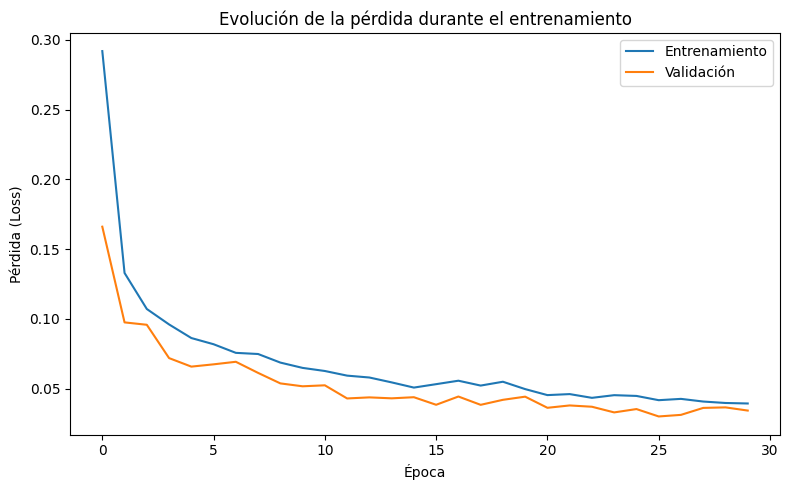

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')

plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.tight_layout()
plt.show()


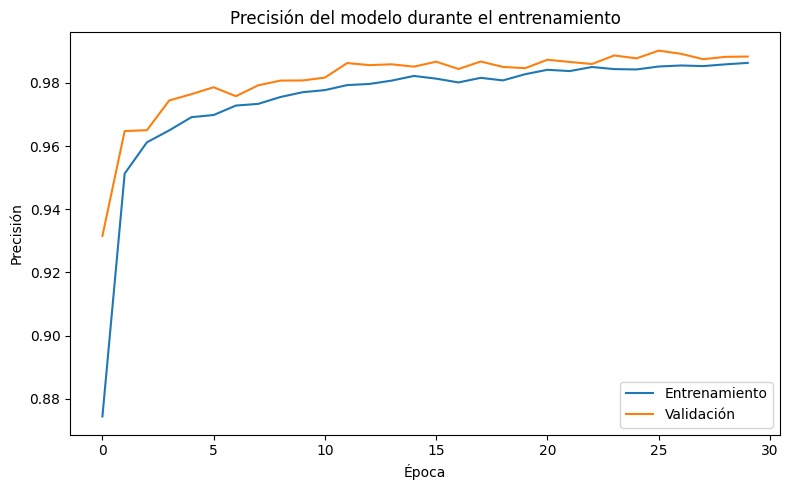

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')

plt.title('Precisión del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [43]:
# Separar features y etiquetas
X_test = df_test.drop(columns=['instancia', 'Label']).values
y_test = df_test['Label'].values

815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy:  0.9604
Precision: 0.9545
Recall:    0.9670
F1-score:  0.9607
ROC-AUC:   0.9934


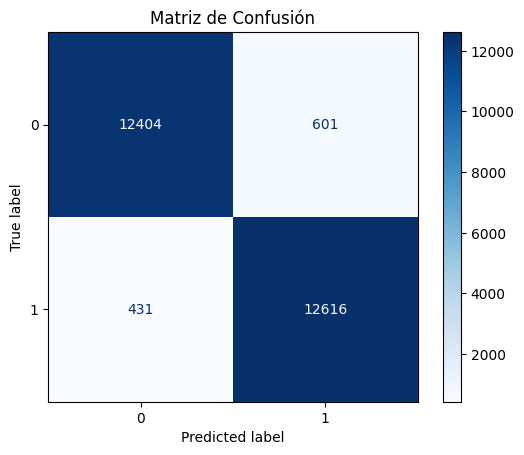

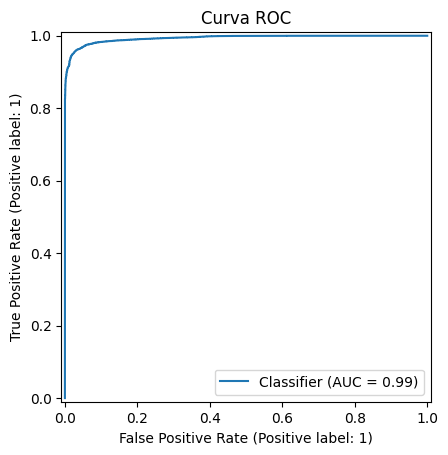

In [44]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# 1. Predecir probabilidades
y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

# 2. Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")

# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# 4. Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC")
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/TFM/T3/Red_Neuronal/modelo/modelo_union_prot_lig_preentrenado_7.h5")